If you want to type along with me, head to [this notebook](https://humboldt.cloudbank.2i2c.cloud/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fbethanyj0%2Fdata111_fa25&branch=main&urlpath=tree%2Fdata111_fa25%2Flectures%2Flec36_live.ipynb) instead. If you prefer follow along by executing the cells, stay in this notebook.

# Lecture 36: Classifiers

In [1]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
ckd = Table.read_table('ckd.csv')
ckd = ckd.relabeled('Blood Glucose Random', 'Glucose').select('Glucose', 'Hemoglobin', 'White Blood Cell Count', 'Class')

In [3]:
patients = Table.read_table('breast-cancer.csv').drop('ID')

def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

## Google Science Fair

In [4]:
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients.show(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


In [5]:
patients.group('Class')

Class,count
0,444
1,239


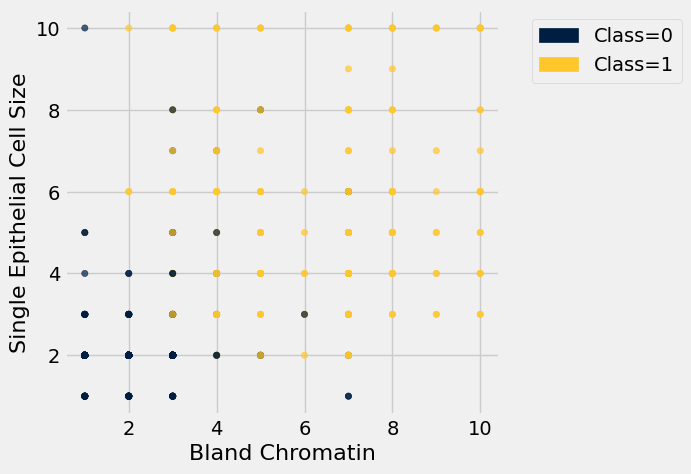

In [6]:
patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Class')

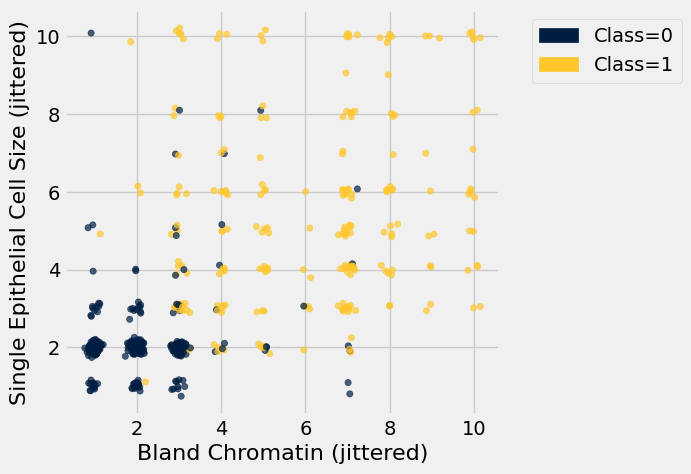

In [7]:
jittered.scatter(0, 1, group='Class')

## Distance ##

As we saw in the slides, the distance between two points $(x_0,y_0)$ and $(x_1,y_1)$ in two dimensions is 

$$D = \sqrt{(x_1-x_0)^2 + (y_1-y_0)^2}$$ 

In three dimensions, the distance between two points $(x_0,y_0,z_0)$ and $(x_1,y_1,z_1)$ is 

$$D = \sqrt{(x_1-x_0)^2 + (y_1-y_0)^2 + (z_1 - z_0)^2}$$


### Activity: Fill in the following functions.

In [8]:
def distance(pt1, pt2):
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt2-pt1)**2))

In [9]:
def row_distance(row1, row2):
    """Return the distance between two numerical rows of a table"""
    row1_array = np.array(row1)
    row2_array = np.array(row2)
    return distance(row1_array,row2_array)

In [10]:
attributes = patients.drop('Class')
attributes.show(3)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
5,1,1,1,2,1,3,1,1
5,4,4,5,7,10,3,2,1
3,1,1,1,2,2,3,1,1


In [11]:
row_distance(attributes.row(0), attributes.row(1))

11.874342087037917

In [12]:
row_distance(attributes.row(0), attributes.row(2))

2.2360679774997898

In [13]:
row_distance(attributes.row(2), attributes.row(2))

0.0

# The Classifier

In [14]:
def distances(training, example):
    """
    Compute distance between example and every row in training.
    Return training augmented with Distance column
    """
    distances = make_array()
    attributes_only = training.drop('Class')
    
    for row in attributes_only.rows:
        distances = np.append(distances, row_distance(row,example)) # append distance between row and example
        
    return training.with_column('Distance_to_ex', distances)

In [15]:
example = attributes.row(21)
example

Row(Clump Thickness=10, Uniformity of Cell Size=5, Uniformity of Cell Shape=5, Marginal Adhesion=3, Single Epithelial Cell Size=6, Bare Nuclei=7, Bland Chromatin=7, Normal Nucleoli=10, Mitoses=1)

In [16]:
distances(patients.exclude(21), example).sort('Distance_to_ex')

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance_to_ex
8,4,4,5,4,7,7,8,2,0,4.3589
10,5,7,4,4,10,8,9,1,1,4.47214
7,4,4,3,4,10,6,9,1,1,5.09902
10,3,6,2,3,5,4,10,2,1,5.38516
10,5,5,6,3,10,7,9,2,1,5.38516
10,6,6,2,4,10,9,7,1,1,5.38516
9,7,7,5,5,10,7,8,3,1,5.56776
10,6,4,3,10,10,9,10,1,1,5.56776
8,7,4,4,5,3,5,10,1,1,5.56776
10,7,7,4,5,10,5,7,2,1,5.74456


In [17]:
def closest(training, example, k):
    """
    Return a table of the k closest neighbors to example
    """
    sorted_distances = distances(training,example).sort('Distance_to_ex')
    return sorted_distances.take(np.arange(k))

In [18]:
closest(patients.exclude(21), example, 5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance_to_ex
8,4,4,5,4,7,7,8,2,0,4.3589
10,5,7,4,4,10,8,9,1,1,4.47214
7,4,4,3,4,10,6,9,1,1,5.09902
10,3,6,2,3,5,4,10,2,1,5.38516
10,5,5,6,3,10,7,9,2,1,5.38516


In [19]:
closest(patients.exclude(21), example, 5).group('Class').sort('count', descending=True)

Class,count
1,4
0,1


In [20]:
def majority_class(topk):
    """
    Return the class with the highest count
    """
    return topk.group('Class').sort('count', descending=True).column(0).item(0)

In [21]:
def classify(training, example, k):
    """
    Return the majority class among the 
    k nearest neighbors of example
    """
    return majority_class(closest(training, example, k))

In [22]:
classify(patients.exclude(21), example, 5)

1

In [23]:
patients.take(21)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
10,5,5,3,6,7,7,10,1,1


In [24]:
new_example = attributes.row(10)
classify(patients.exclude(10), new_example, 5)

0

In [25]:
patients.take(10)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
1,1,1,1,1,1,3,1,1,0


In [26]:
another_example = attributes.row(15)
classify(patients.exclude(15), another_example, 5)

0

In [27]:
patients.take(15)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
7,4,6,4,6,1,4,3,1,1


## Review of the Steps ##

- `distance(pt1, pt2)`: Returns the distance between the arrays `pt1` and `pt2`
- `row_distance(row1, row2)`: Returns the distance between the rows `row1` and `row2`
- `distances(training, example)`: Returns a table that is `training` with an additional column `'Distance'` that contains the distance between `example` and each row of `training`
- `closest(training, example, k)`: Returns a table of the rows corresponding to the k smallest distances 
- `majority_class(topk)`: Returns the majority class in the `'Class'` column
- `classify(training, example, k)`: Returns the predicted class of `example` based on a `k` nearest neighbors classifier using the historical sample `training`

## Accuracy of a Classifier ##

In [41]:
patients.num_rows

683

In [42]:
shuffled = patients.sample(with_replacement=False) # Randomly permute the rows
training_set = shuffled.take(np.arange(342))
test_set  = shuffled.take(np.arange(342, 683))

In [43]:
def evaluate_accuracy(training, test, k):
    """Return the proportion of correctly classified examples 
    in the test set"""
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        c = classify(training, test_attributes.row(i), k)
        num_correct = num_correct + (c == test.column('Class').item(i))
    return num_correct / test.num_rows

In [44]:
evaluate_accuracy(training_set, test_set, 5)

0.967741935483871

In [45]:
evaluate_accuracy(training_set, test_set, 3)

0.9648093841642229

In [46]:
evaluate_accuracy(training_set, test_set, 11)

0.9706744868035191

In [47]:
evaluate_accuracy(training_set, test_set, 1)

0.9618768328445748

# Standardize if Necessary

In [48]:
def standard_units(x):
    return (x - np.average(x)) / np.std(x)

In [49]:
ckd_new = ckd.select('Class').with_columns(
    'Glucose_su', standard_units(ckd.column('Glucose')),
    'Hemoglobin_su', standard_units(ckd.column('Hemoglobin')),
    'WBC_su', standard_units(ckd.column('White Blood Cell Count'))
)

In [50]:
ckd_new

Class,Glucose_su,Hemoglobin_su,WBC_su
1,-0.221549,-0.865744,-0.569768
1,-0.947597,-1.45745,1.16268
1,3.84123,-1.00497,-1.27558
1,0.396364,-2.81488,0.809777
1,0.643529,-2.08395,0.232293
1,-0.561402,-1.35303,-0.505603
1,2.04928,-0.413266,0.360623
1,-0.947597,-1.28342,3.34429
1,1.87936,-1.10939,-0.409356
1,0.489051,-1.35303,1.96475


In [51]:
eshuffled = ckd_new.sample(with_replacement=False) 
training_set = shuffled.take(np.arange(74))
test_set  = shuffled.take(np.arange(74, 148))

In [52]:
evaluate_accuracy(training_set, test_set, 3)

0.9594594594594594

In [53]:
shuffled = ckd.sample(with_replacement=False) 
training_set = shuffled.take(np.arange(74))
test_set  = shuffled.take(np.arange(74, 148))

In [54]:
evaluate_accuracy(training_set, test_set, 3)

0.8648648648648649